In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

## EDA

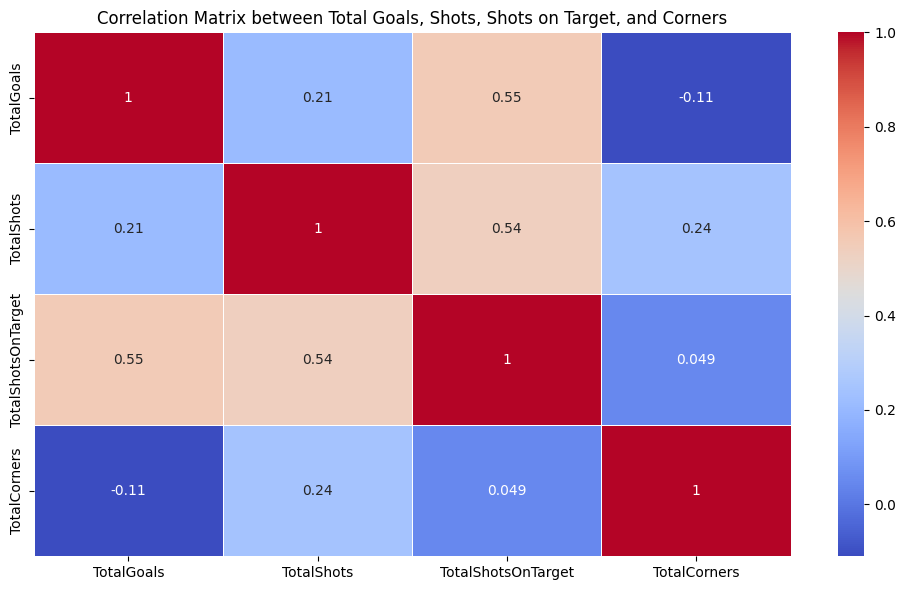

In [104]:
file_path = '2021-2022.csv'
data = pd.read_csv(file_path)

# Filter relevant columns: Date, HomeTeam, AwayTeam, B365>2.5, FTHG, FTAG, HS, AS, HST, AST, HC, AC
data_filtered = data[['Date', 'HomeTeam', 'AwayTeam', 'B365>2.5', 'FTHG', 'FTAG', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC']]

# Drop rows with missing values in the relevant columns
data_filtered.dropna(subset=['Date', 'B365>2.5', 'FTHG', 'FTAG', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC'], inplace=True)

# Calculate Full Time Total Goals, Total Shots, Total Shots on Target, and Total Corners
data_filtered['TotalGoals'] = data_filtered['FTHG'] + data_filtered['FTAG']
data_filtered['TotalShots'] = data_filtered['HS'] + data_filtered['AS']
data_filtered['TotalShotsOnTarget'] = data_filtered['HST'] + data_filtered['AST']
data_filtered['TotalCorners'] = data_filtered['HC'] + data_filtered['AC']

# Calculate correlations
data_corr = data_filtered[['TotalGoals', 'TotalShots', 'TotalShotsOnTarget', 'TotalCorners']].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(data_corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix between Total Goals, Shots, Shots on Target, and Corners')
plt.tight_layout()
plt.show()

## Goals

#### Fixed bet

In [176]:
file_path = '2024-2025.csv'  # Replace with your CSV file path
data = pd.read_csv(file_path)

# Filter relevant columns: Date, HomeTeam, AwayTeam, B365>2.5, FTHG, FTAG
data_filtered = data[['Date', 'HomeTeam', 'AwayTeam', 'B365>2.5', 'B365C>2.5', 'B365<2.5','FTHG', 'FTAG']]

# Drop rows with missing values in the relevant columns
data_filtered.dropna(subset=['Date', 'B365>2.5', 'B365C>2.5', 'B365<2.5','FTHG', 'FTAG'], inplace=True)

# Convert 'Date' to datetime format
data_filtered['Date'] = pd.to_datetime(data_filtered['Date'], errors='coerce', dayfirst=True)

# Drop rows where the date could not be parsed
data_filtered.dropna(subset=['Date'], inplace=True)

# Sort data by date
data_filtered.sort_values(by='Date', inplace=True)

# Calculate Full Time Total Goals
data_filtered['TotalGoals'] = data_filtered['FTHG'] + data_filtered['FTAG']

#daily_best_bet = data_filtered[data_filtered['B365C>2.5'] <= data_filtered['B365>2.5']]
#daily_best_bet = data_filtered.loc[data_filtered.groupby('Date')['B365>2.5'].idxmin()]
daily_best_bet = data_filtered

# Initialize variables for P&L calculation
cumulative_pnl = []
current_pnl = 0
bet_amount = 100
# Iterate over each selected match to calculate cumulative P&L
for _, match in daily_best_bet.iterrows():
    if match['B365>2.5'] > match['B365<2.5']:
        if match['TotalGoals'] > 2.5:
            # If the bet wins, calculate profit based on the odds
            profit = (match['B365>2.5'] - 1) * bet_amount
            current_pnl += profit
        else:
            # If the bet loses, subtract the stake
            current_pnl -= bet_amount
        cumulative_pnl.append(current_pnl)
    else:
        if match['TotalGoals'] > 2.5:
            current_pnl -= bet_amount
        else:
            profit = (match['B365<2.5'] - 1) * bet_amount
            current_pnl += profit
        cumulative_pnl.append(current_pnl)

# Plot the P&L trend over time
plt.figure(figsize=(10, 6))
plt.plot(daily_best_bet['Date'], cumulative_pnl, marker='o', linestyle='-', color='b')
plt.xlabel('Date')
plt.ylabel('Cumulative P&L (£)')
plt.title('P&L Trend Over the Season for Simple Betting Strategy with Adjusted Bet Amounts')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

#### Adaptive bet

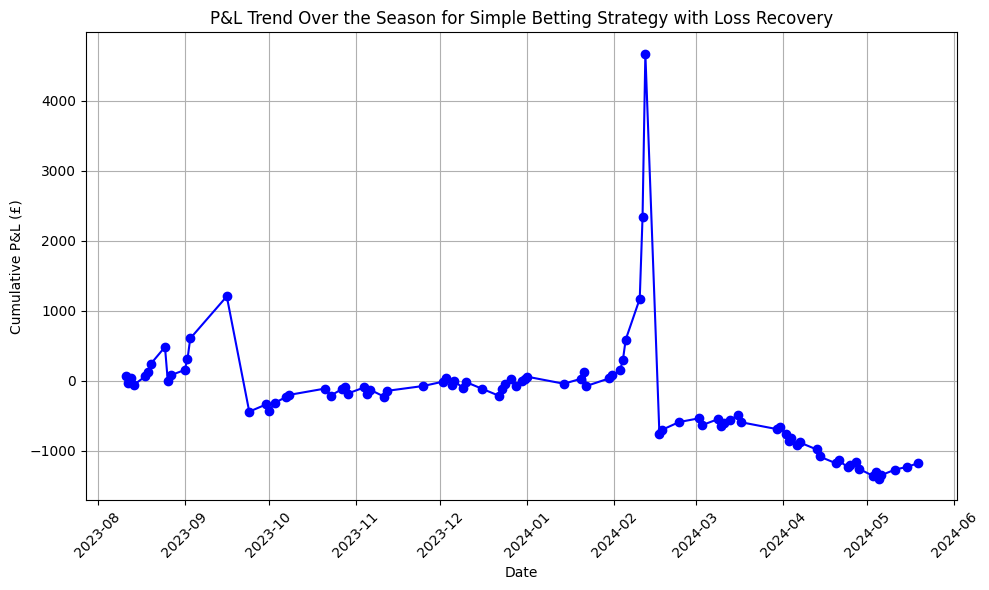

In [186]:
file_path = '2023-2024.csv'  # Replace with your CSV file path
data = pd.read_csv(file_path)
data_filtered = data[['Date', 'HomeTeam', 'AwayTeam', 'B365>2.5', 'B365C>2.5', 'FTHG', 'FTAG']]
# Drop rows with missing values in the relevant columns
data_filtered.dropna(subset=['Date', 'B365>2.5', 'B365C>2.5','FTHG', 'FTAG'], inplace=True)

# Convert 'Date' to datetime format
data_filtered['Date'] = pd.to_datetime(data_filtered['Date'], errors='coerce', dayfirst=True)

# Drop rows where the date could not be parsed
data_filtered.dropna(subset=['Date'], inplace=True)

# Sort data by date
data_filtered.sort_values(by='Date', inplace=True)

# Calculate Full Time Total Goals
data_filtered['TotalGoals'] = data_filtered['FTHG'] + data_filtered['FTAG']
data_filtered = data_filtered[data_filtered['B365C>2.5'] <= data_filtered['B365>2.5']]

daily_best_bet = data_filtered.loc[data_filtered.groupby('Date')['B365C>2.5'].idxmax()]
daily_best_bet.reset_index(drop=True, inplace=True)

# Initialize variables for P&L calculation
cumulative_pnl = []
current_pnl = 0
amount_init = 100
temp_loss = 0

# Iterate over each selected match to calculate cumulative P&L
for i, match in daily_best_bet.iterrows():
    if current_pnl>0:
        bet_amount = max(100, current_pnl / (match['B365C>2.5'] - 1) )
    else:
        bet_amount = amount_init
    
    if match['TotalGoals'] > 2.5:
        profit = (match['B365C>2.5'] - 1) * bet_amount
        current_pnl += profit
        # Reset bet amount to 100 and temp_loss to 0 after a win
        #bet_amount = 100
        temp_loss = 0
    else:
        # If the bet loses, subtract the stake and update temp_loss
        current_pnl -= bet_amount
        temp_loss += bet_amount
        # Update bet amount to recover previous losses
        #bet_amount = abs(current_pnl / (match['B365C>2.5'] - 1) )
    
    cumulative_pnl.append(current_pnl)

# Plot the P&L trend over time
plt.figure(figsize=(10, 6))
plt.plot(daily_best_bet['Date'], cumulative_pnl, marker='o', linestyle='-', color='b')
plt.xlabel('Date')
plt.ylabel('Cumulative P&L (£)')
plt.title('P&L Trend Over the Season for Simple Betting Strategy with Loss Recovery')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## Handicap

#### Weak team

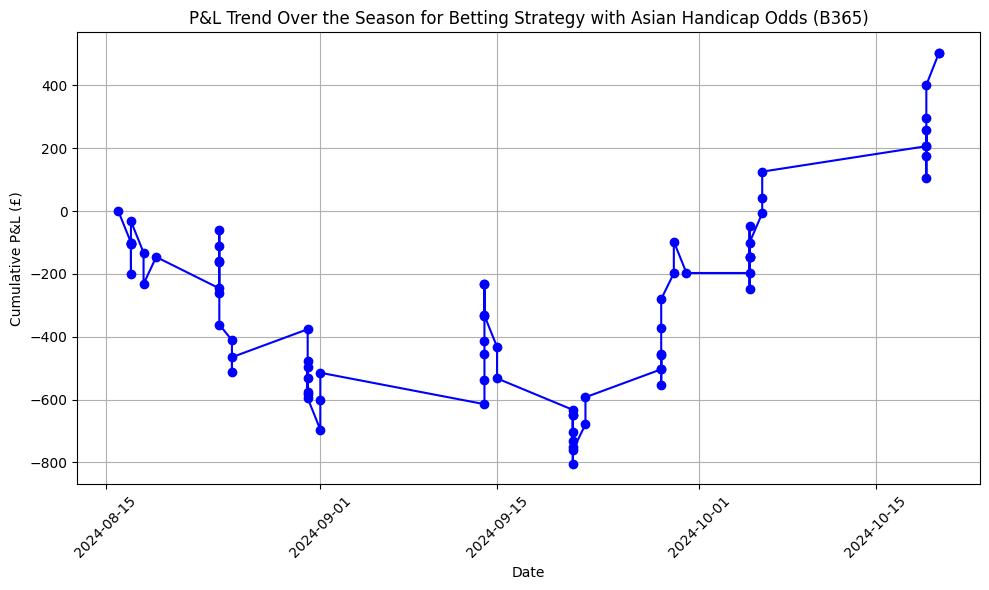

In [180]:
file_path = '2024-2025.csv'  # Replace with your CSV file path
data = pd.read_csv(file_path)

# Filter relevant columns: Date, HomeTeam, AwayTeam, AHh, B365AHH, B365AHA, FTHG, FTAG
relevant_columns = ['Date', 'HomeTeam', 'AwayTeam', 'AHh', 'B365AHH', 'B365AHA', 'FTHG', 'FTAG']
data_filtered = data[relevant_columns]

# Drop rows with missing values in the relevant columns
data_filtered.dropna(subset=['Date', 'AHh', 'B365AHH', 'B365AHA', 'FTHG', 'FTAG'], inplace=True)

# Convert 'Date' to datetime format
data_filtered['Date'] = pd.to_datetime(data_filtered['Date'], errors='coerce', dayfirst=True)

# Drop rows where the date could not be parsed
data_filtered.dropna(subset=['Date'], inplace=True)

# Sort data by date
data_filtered.sort_values(by='Date', inplace=True)

# Calculate Full Time Total Goals
data_filtered['TotalGoals'] = data_filtered['FTHG'] + data_filtered['FTAG']

# Select the match where the weaker team has the highest Asian handicap odds for each match day
weaker_team_bets = []
for _, match in data_filtered.iterrows():
    if match['AHh'] > 0:
        weaker_team_bets.append({'Date': match['Date'], 'Team': 'HomeTeam', 'Odds': match['B365AHH'], 'FTHG': match['FTHG'], 'FTAG': match['FTAG'], 'AHh': match['AHh']})
    elif match['AHh'] < 0:
        weaker_team_bets.append({'Date': match['Date'], 'Team': 'AwayTeam', 'Odds': match['B365AHA'], 'FTHG': match['FTHG'], 'FTAG': match['FTAG'], 'AHh': match['AHh']})
    else:
        weaker_team_bets.append({'Date': match['Date'], 'Team': 'HomeTeam', 'Odds': match['B365AHH'], 'FTHG': match['FTHG'], 'FTAG': match['FTAG'], 'AHh': match['AHh']})

weaker_team_bets_df = pd.DataFrame(weaker_team_bets)
#daily_best_bet = weaker_team_bets_df.loc[weaker_team_bets_df.groupby('Date')['Odds'].idxmax()]
daily_best_bet = weaker_team_bets_df
# Initialize variables for P&L calculation
cumulative_pnl = []
current_pnl = 0
bet_amount = 100

# Iterate over each selected match to calculate cumulative P&L
for _, match in daily_best_bet.iterrows():
    # Calculate outcome of the bet
    if match['AHh'] >= 0:
        dif = match['FTHG'] + match['AHh'] - match['FTAG']
    elif match['AHh'] < 0:
        # Bet on away team
        dif = match['FTAG'] + abs(match['AHh']) - match['FTHG']
    
    if dif >= 0.5:
        profit = (match['Odds'] - 1) * bet_amount
    elif dif==0.25:
        profit = 0.5 * (match['Odds'] - 1) * bet_amount  # Half profit
    elif dif == 0:
        profit = 0
    elif dif==-0.25:
        profit = -0.5*bet_amount
    else:
        profit = -bet_amount  # Full loss
        
    current_pnl += profit
    cumulative_pnl.append(current_pnl)

# Plot the P&L trend over time
plt.figure(figsize=(10, 6))
plt.plot(daily_best_bet['Date'], cumulative_pnl, marker='o', linestyle='-', color='b')
plt.xlabel('Date')
plt.ylabel('Cumulative P&L (£)')
plt.title('P&L Trend Over the Season for Betting Strategy with Asian Handicap Odds (B365)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

#### Strong team

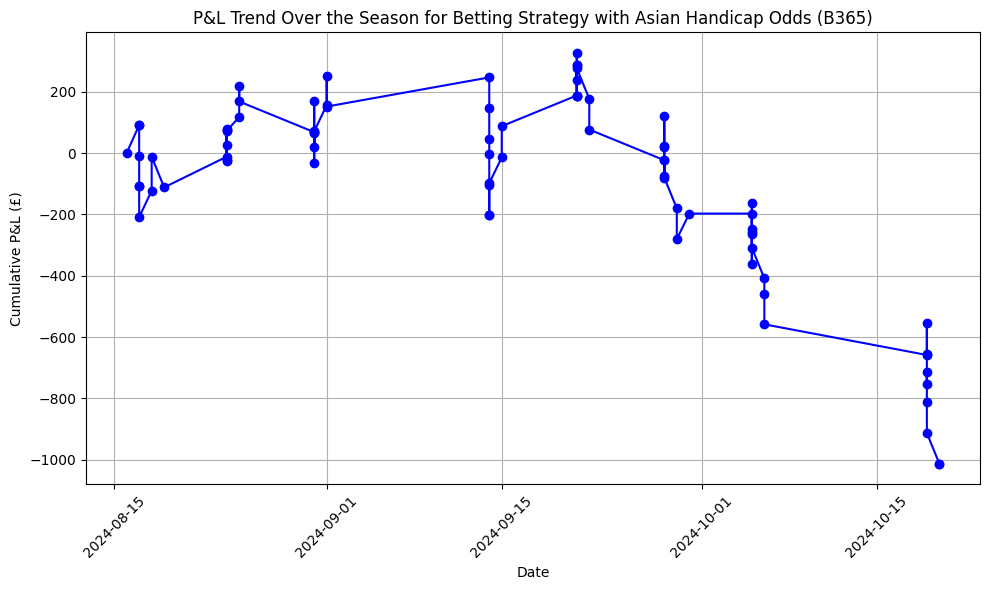

In [179]:
file_path = '2024-2025.csv'  # Replace with your CSV file path
data = pd.read_csv(file_path)

# Filter relevant columns: Date, HomeTeam, AwayTeam, AHh, B365AHH, B365AHA, FTHG, FTAG
relevant_columns = ['Date', 'HomeTeam', 'AwayTeam', 'AHh', 'B365AHH', 'B365AHA', 'FTHG', 'FTAG']
data_filtered = data[relevant_columns]

# Drop rows with missing values in the relevant columns
data_filtered.dropna(subset=['Date', 'AHh', 'B365AHH', 'B365AHA', 'FTHG', 'FTAG'], inplace=True)

# Convert 'Date' to datetime format
data_filtered['Date'] = pd.to_datetime(data_filtered['Date'], errors='coerce', dayfirst=True)

# Drop rows where the date could not be parsed
data_filtered.dropna(subset=['Date'], inplace=True)

# Sort data by date
data_filtered.sort_values(by='Date', inplace=True)

# Calculate Full Time Total Goals
data_filtered['TotalGoals'] = data_filtered['FTHG'] + data_filtered['FTAG']

# Select the match where the weaker team has the highest Asian handicap odds for each match day
strong_team_bets = []
for _, match in data_filtered.iterrows():
    if match['AHh'] > 0:
        strong_team_bets.append({'Date': match['Date'], 'Team': 'AwayTeam', 'Odds': match['B365AHA'], 'FTHG': match['FTHG'], 'FTAG': match['FTAG'], 'AHh': match['AHh']})
        #weaker_team_bets.append({'Date': match['Date'], 'Team': 'HomeTeam', 'Odds': match['B365AHH'], 'FTHG': match['FTHG'], 'FTAG': match['FTAG'], 'AHh': match['AHh']})
    elif match['AHh'] < 0:
        strong_team_bets.append({'Date': match['Date'], 'Team': 'HomeTeam', 'Odds': match['B365AHH'], 'FTHG': match['FTHG'], 'FTAG': match['FTAG'], 'AHh': match['AHh']})
        #weaker_team_bets.append({'Date': match['Date'], 'Team': 'AwayTeam', 'Odds': match['B365AHA'], 'FTHG': match['FTHG'], 'FTAG': match['FTAG'], 'AHh': match['AHh']})
    else:
        strong_team_bets.append({'Date': match['Date'], 'Team': 'HomeTeam', 'Odds': match['B365AHH'], 'FTHG': match['FTHG'], 'FTAG': match['FTAG'], 'AHh': match['AHh']})

strong_team_bets_df = pd.DataFrame(strong_team_bets)
#daily_best_bet = weaker_team_bets_df.loc[weaker_team_bets_df.groupby('Date')['Odds'].idxmax()]
daily_best_bet = strong_team_bets_df
# Initialize variables for P&L calculation
cumulative_pnl = []
current_pnl = 0
bet_amount = 100

# Iterate over each selected match to calculate cumulative P&L
for _, match in daily_best_bet.iterrows():
    # Calculate outcome of the bet
    if match['AHh'] > 0:
        dif = match['FTAG'] - (match['FTHG'] + match['AHh'])
    elif match['AHh'] <= 0:
        dif = match['FTHG'] - (match['FTAG'] + abs(match['AHh']))
    
    if dif >= 0.5:
        profit = (match['Odds'] - 1) * bet_amount
    elif dif==0.25:
        profit = 0.5 * (match['Odds'] - 1) * bet_amount  # Half profit
    elif dif == 0:
        profit = 0
    elif dif==-0.25:
        profit = -0.5*bet_amount
    else:
        profit = -bet_amount  # Full loss
        
    current_pnl += profit
    cumulative_pnl.append(current_pnl)

# Plot the P&L trend over time
plt.figure(figsize=(10, 6))
plt.plot(daily_best_bet['Date'], cumulative_pnl, marker='o', linestyle='-', color='b')
plt.xlabel('Date')
plt.ylabel('Cumulative P&L (£)')
plt.title('P&L Trend Over the Season for Betting Strategy with Asian Handicap Odds (B365)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()